#### General Import

In [1]:
import re
import json
import string
import pickle
import operator
import numpy as np
import pandas as pd
from nltk import ngrams
from nltk import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.preprocessing import normalize
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
tqdm_notebook.pandas()
%matplotlib inline

In [46]:
%run ./Library.ipynb

In [4]:
# read dataset & clean rows
data = pd.read_excel('Data\\2000 dang_Ndang.xlsx')
data = data.drop(['Unnamed: 0'], axis=1)
data = data.rename(columns = {'Long Text Notif Header': 'Long Text Notif'})
data = data.rename(columns = {'SORT Field': 'Tag Number'})
data = data.drop_duplicates(subset='Long Text Notif')
data = data[pd.notnull(data['Long Text Notif'])]

In [5]:
data.head()

,Unnamed: 0.1,Notif Number,Unnamed: 2,Functionnal Location,Equipment,Assembly,Required Start Date,Required Start Time,Required End Date,Required End Time,...,Unnamed: 118,Notif Desc,Long Text Notif,Activity Code Desc,Activity Text,Cause Code Desc,Cause Text,Damage Desc,Dangereux / pas Dangereux,Détectable / pas Détectable
0,283595,000013491285,NaN,GO-PP -FIC10670,ZRN3-027458,,20170701,133733,20170703,235900,...,NaN,fuite externe prpylène PE,01.07.2017 13:37:33 LUDOVIC TERNON (J0218441) ...,NaN,NaN,Général ou inconnue,voir texte,Fuite externe - 0 à 100 kg,NonDangereux,Détectable
1,283577,13691000,NaN,RN-E15-IN-F3771 -82FT3771,ZRN1-174012,,20180603,113026,20180616,0,...,NaN,plus de mesure,03.06.2018 11:30:26 Benoit CHRETIEN (J0017933)...,NaN,NaN,Usure,,Indication d'instrument anormale,NonDangereux,Détectable
2,3040,12395448,NaN,RN-B11-IN-B3607 -67BSL3607,000000000010069844,,20120327,194949,20120510,0,...,NaN,veilleuse 7 du H3B,27.03.2012 19:49:50 M. NORD SDC OPÉRATEURS OUE...,NaN,NaN,Obstruction/colmatage,,Autre,Non dangereux,Détectable
3,297,12637028,NaN,RN-B11-IN-B3107 -67BSL3107,000000000010069836,,20130412,145546,20130426,0,...,NaN,"Veilleuse 7 du H3A, ne s'allume plus",12.04.2013 14:55:46 M. NORD SDC OPÉRATEURS OUE...,Remplacement,,Maintenance préventive,,Colmaté / Obstrué,Non dangereux,Détectable
4,264636,12638714,NaN,RN-B11-IN-B4111 -67BSL4111,000000000010069934,,20130416,122901,20130426,0,...,NaN,veilleuse 11 du H4 HS,16.04.2013 12:29:01 M. NORD SDC OPÉRATEURS OUE...,Entretien,VEILLEUSE,Obstruction/colmatage,PRESENCE H2,En panne,NonDangereux,Détectable


In [6]:
data.shape

(2000, 128)

#### Generate similar notifications from the validated data

In [153]:
# Read validated file
valid_data = pd.read_excel('dang_Ndang_2.xlsx')
valid_data = valid_data.drop(['Unnamed: 0'], axis=1)

In [154]:
valid_data.head()

,Notif Number,Equipment Catalog,Functionnal Location,Long Text Notif,Notif Desc,Activity Code Desc,Activity Text,Cause Code Desc,Cause Text,Damage Desc,Label
0,12654930,NaN,RN-B30-IN-L4331 -77LV4331,14.05.2013 18:12:37 M. OPERATEURS DG04 (Z00706...,Problème régulation niveau D406 LV4331,NaN,NaN,Obstruction/colmatage,,Colmaté / Obstrué,Dangereux
1,G10685099,I,GO-PEL-PSL4401-41,07.10.2017 16:27:49 Raghava-Rao PALERU (FF-PA-...,PSL 4401-41 toujours actif,Remise en état,SYMPTOM:Mesures Anormales,NaN,NaN,En panne,Dangereux
2,G10202807,I,GO-VAP-PAL724,13.07.2007 14:58:07 Thierry BERNARD (A0001281...,pal 724 sur détection incendie 2M29,Remise en état,SYMPTOM:Perte de Fonction Totale,NaN,NaN,En panne,Dangereux
3,G10202749,I,GO-BCC-PSL1522,13.07.2007 11:16:13 Stéphane JEANNE (A0001538...,Cde et pose de repère Appont 2,Remise en état,SYMPTOM:Preventif,NaN,NaN,En panne,NonDangereux
4,G10711798,I,GO-BCC-PSL1522,07.06.2012 18:26:10 Stephane JEANNE (J0218016...,Assistance au test IIPS 13,Remise en état,SYMPTOM:Preventif,NaN,NaN,En panne,NonDangereux


In [155]:
valid_data.shape

(109, 11)

In [156]:
valid_data.Label.value_counts()

NonDangereux    85
Dangereux       24
Name: Label, dtype: int64

#### Processing Data

In [80]:
# Select only the Instruments
instrument_df = data.copy()
instrument_df = instrument_df.loc[~(instrument_df['Equipment Catalog'].eq('A')| data['Equipment Catalog'].eq('E'))]
# Keep only notifications that describe failures
instrument_df = instrument_df.loc[~instrument_df['Damage Desc'].str.contains('Maintenance Préventive', na=False)] # I'm not sure

In [81]:
instrument_df.shape

(47036, 117)

In [54]:
def SIL_clean_text(text):
    text = text.lower()
    bloc_text = re.compile(r'\d{2}.\d{2}.\d{4} \d{2}:\d{2}:\d{2}').split(text)[1:]
    if bloc_text:
        bloc_text = [re.sub(r'(.*\(.*\d{2}\))|(.*\(.*\d.\))', '', bloc) for bloc in bloc_text]
        text = ' '.join(bloc_text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = remove_special_caracter(text)
    text = re.sub(r'\<(.*?)\/\>', ' ', str(text))
    text = re.sub('<(\/)?( )?br>', ' ', str(text))
    # Remove punctuation
    text = text.translate(dict.fromkeys(map(ord, string.punctuation), ' '))
    # Remove stopwords
    stop_words = stopwords.words('french')
    with open('stopwords-fr.json', encoding='utf-8') as data_file:
        data = json.load(data_file)
    stop_words += list(data)
    stop_words += ['temperature','pression','bar','produit','détail','oui','ok', 'tél', '°c']  # Stopword added by Fatma
    stop_words.remove('ne')
    stop_words.remove('pas')
    descwords = text.split()
    text = ' '.join([word for word in descwords if word not in stop_words])
    return text

##### Compute similarity using word2vec

In [42]:
# Tokenization
corpus = [SIL_clean_text(text) for text in instrument_df['Long Text Notif']]
tokens = [word_tokenize(text) for text in corpus]

In [44]:
# Build word2vec model
word2vec_model = Word2Vec(tokens,
                          min_count=3,   # Ignore words that appear less than this
                          size=200,      # Dimensionality of word embeddings
                          workers=2,     # Number of processors (parallelisation)
                          window=5,      # Context window for words during training
                          iter=30)       # Number of epochs training over corpus

In [45]:
def vectorize(sentence, model):
    sentence_vec =[]
    numw = 0
    for word in sentence:
        try:
            if numw == 0:
                sentence_vec = model[word]
            else:
                sentence_vec = np.add(sentence_vec, model[word])
            numw += 1
        except:
            pass
    return np.asarray(sentence_vec) / numw

In [46]:
def l2_normalize(v):
    norm = np.sqrt(np.sum(np.square(v)))
    return v / norm

def word2vec_cosine_similarity(l1, l2):
    x = l2_normalize(vectorize(l1, word2vec_model))
    y = l2_normalize(vectorize(l2, word2vec_model))
    if x.shape[0] != 0 and y.shape[0] != 0:
        # Cosine similarity
        dot = np.dot(x, y)
        norma = np.linalg.norm(x)
        normb = np.linalg.norm(y)
        return dot / (norma * normb)
    else:
        return 0
    
def compute_similarity_(data, processing_column, valid_data):
    df = data.copy()
    # This treatment concerne the tagged data
    proc = valid_data[processing_column].apply(SIL_clean_text)
    # Create text containing all text which cacarterise the label
    text = ' '.join(proc)
    # Take the n top words 
    tokens = word_tokenize(text)
    vocab_length = text_length_avg(proc)
    vocab = [word[0] for word in Counter(tokens).most_common(vocab_length)]
    # Let's move to computation of similarity
    print('compute similarity...')
    df['Similarity Score'] = df[processing_column].progress_apply(lambda row: word2vec_cosine_similarity(vocab, word_tokenize(clean_text(row))))    
    df = df.nlargest(3000, 'Similarity Score')
    return df

##### Compute Similarity using Jaccard Similarity

In [442]:
instrument_df['proc'] = instrument_df['Long Text Notif'].apply(lambda row: SIL_clean_text(row))
instrument_df = instrument_df.drop_duplicates(subset='proc')
instrument_df.shape

(37218, 118)

In [161]:
def text_length_avg(proc):
    x = proc.apply(lambda row: len(word_tokenize(row)))
    return round(x.mean())

In [27]:
def jaccard_similarity(l1, l2):
    l1_length = len(l1)
    l2_length = len(l2)
    intersection_length = len(set(l1).intersection(set(l2)))
    return intersection_length / (l1_length + l2_length + intersection_length)

def compute_similarity(data, valid_data):
    df = data.copy()
    # This treatment concerne the tagged data
    proc = valid_data.apply(SIL_clean_text)
    # Create text containing all text which cacarterise the label
    text = ' '.join(proc)
    # Take the n top words 
    tokens = word_tokenize(text)
    vocab_length = text_length_avg(proc)
    vocab = [word[0] for word in Counter(tokens).most_common(vocab_length)]
    # Let's move to computation of similarity
    print('compute similarity...')
    df['Similarity Score'] = df['proc'].progress_apply(lambda row: jaccard_similarity(vocab, word_tokenize(row)))    
    df = df.nlargest(3000, 'Similarity Score')
    return df

In [83]:
dang_df = compute_similarity(instrument_df, valid_data.loc[valid_data.Label == 'Dangereux']['Long Text Notif'])
dang_df = dang_df.assign(Label='Dangereux')

compute similarity...


In [84]:
Ndang_df = compute_similarity(instrument_df[~instrument_df.index.isin(dang_df.index)], valid_data.loc[valid_data.Label == 'NonDangereux']['Long Text Notif'])
Ndang_df = Ndang_df.assign(Label='NonDangereux')

compute similarity...


In [85]:
df = pd.concat([dang_df, Ndang_df], axis=0)
df = df.drop(['proc', 'Similarity Score'], axis=1)

In [86]:
df.head()

,Notif Number,Notif Desc,Functionnal Location,Equipment,Assembly,Required Start Date,Required Start Time,Required End Date,Required End Time,Priority,...,Tag Number,Main asset subnumber,Cost Center,Cost Center Desc,WBS,StandgOrder,Settlement Order,planning group,Catalog Profile,Label
281303,13309444,UV1916 - Rid.d'eau D901 : ne s'ouvre pas,RN-B50-IN-U1916 -79UVS1916,ZRN1-172050,,20161009.0,104339.0,20170219.0,0,3,...,79UVS1916,,1N1MB50,DGO5 SUD,0.0,,,A05,ZPM01621,Dangereux
281294,13309440,UVS1914 - Rid.d'eau D901: ne s'ouvre pas,RN-B50-IN-U1914 -79UVS1914,ZRN1-172046,,20161009.0,102412.0,20170219.0,0,3,...,79UVS1914,,1N1MB50,DGO5 SUD,0.0,,,A05,ZPM01621,Dangereux
267950,12265171,grosse fuite d'air sur l'UV,RN-C59-IN-U8216 -50UV8216,ZRN1-021194,,20110916.0,63508.0,20110920.0,0,2,...,50UV8216,,1N1MC59,DISTILLATION5,0.0,,,A01,ZPM01621,Dangereux
281305,13137850,UVS1916 - Rideau d'eau D901: PB ouvert.,RN-B50-IN-U1916 -79UVS1916,ZRN1-172050,,20151107.0,112723.0,20151207.0,0,3,...,79UVS1916,,1N1MB50,DGO5 SUD,0.0,,,A05,ZPM01621,Dangereux
277172,000013470799,UVS1110 - H901(Pil.N°1) : Bloquée fermée,RN-B50-IN-U1110 -79UVS1110,ZRN1-172013,,20170613.0,72323.0,20170623.0,0,2,...,79UVS1110,,1N1MB50,DGO5 SUD,0.0,,,A05,ZPM01621,Dangereux


In [444]:
df.shape

(6000, 119)

In [166]:
df.to_excel('6000 dang_Ndang.xlsx')

In [97]:
df.head()

,Notif Number,Unnamed: 2,Functionnal Location,Equipment,Assembly,Required Start Date,Required Start Time,Required End Date,Required End Time,Priority,...,Notif Desc,Long Text Notif,Activity Code Desc,Activity Text,Cause Code Desc,Cause Text,Damage Desc,Dangereux / pas Dangereux,Détectable / pas Détectable,Text
0,13309444,NaN,RN-B50-IN-U1916 -79UVS1916,ZRN1-172050,,20161009,104339,20170219,0,3,...,UV1916 - Rid.d'eau D901 : ne s'ouvre pas,09.10.2016 10:43:40 M. OPERATEURS DGO3/POMPIST...,Contrôle,Recherche dysfonctionnement,Blocage,,Défaillance à l'ouverture sur sollicitat,Dangereux,NaN,eau incendie bars isolable echafaudage panne e...
1,13309440,NaN,RN-B50-IN-U1914 -79UVS1914,ZRN1-172046,,20161009,102412,20170219,0,3,...,UVS1914 - Rid.d'eau D901: ne s'ouvre pas,09.10.2016 10:24:12 M. OPERATEURS DGO3/POMPIST...,Contrôle,Recherche dysfonctionnement,Blocage,,Défaillance à l'ouverture sur sollicitat,Dangereux,NaN,eau incendie bars isolable echafaudage panne e...
2,12265171,NaN,RN-C59-IN-U8216 -50UV8216,ZRN1-021194,,20110916,63508,20110920,0,2,...,grosse fuite d'air sur l'UV,16.09.2011 06:35:10 M. OPÉRATEURS VISCO (Z0012...,NaN,NaN,Erosion,,Fuite externe - 100 à 1000 kg,Dangereux,NaN,isolable echafaudage panne grosse fuite air uv...
3,13137850,NaN,RN-B50-IN-U1916 -79UVS1916,ZRN1-172050,,20151107,112723,20151207,0,3,...,UVS1916 - Rideau d'eau D901: PB ouvert.,07.11.2015 11:27:25 M. OPERATEURS DGO3/POMPIST...,NaN,NaN,Maintenance préventive,,Autre,Dangereux,NaN,eau service isolable echafaudage panne encrass...
4,000013470799,NaN,RN-B50-IN-U1110 -79UVS1110,ZRN1-172013,,20170613,72323,20170623,0,2,...,UVS1110 - H901(Pil.N°1) : Bloquée fermée,13.06.2017 07:23:25 M. OPERATEURS DGO3/POMPIST...,Contrôle,Vérif. vanne,Blocage,,Défaillance de fonctionnemnt sur sollici,Dangereux,NaN,inconsables isolable echafaudage panne uv bloq...


### Classification

In [105]:
df = pd.read_excel('Data\\dataset.xlsx')
df = df.drop(['Unnamed: 0'], axis=1)
# We will perform classification on Dang/Ndang
df = df.rename(columns = {'Dangereux / pas Dangereux': 'Label'})

In [106]:
# After validation we are multi name of NonDangereux category
df['Label'] = df['Label'].replace(['Non dangereux', 'Non Dangereux', 'Non angereux', 'Non dangereux '], 'NonDangereux')
df['Label'] = df['Label'].replace('dangereux', 'Dangereux')
df['Label'].unique()

array(['NonDangereux', 'Dangereux'], dtype=object)

In [107]:
df['Label'].value_counts()

NonDangereux    3147
Dangereux        615
Name: Label, dtype: int64

In [108]:
# def concatenate_column: function returns the concatenated text from Dataframe columns
def concatenate_column(row, columns):
    column_text = []
    for col in columns:
        if type(row[col]) == str:
            column_text.append(SIL_clean_text(row[col]))
    return ' '.join([text for text in column_text])

In [109]:
df['Text'] = df.progress_apply(lambda row: concatenate_column(row, ['Long Text Notif','Notif Desc','Long Text Item',
                                                                    'Activity Long Text','Activity Text',
                                                                    'Cause Text','Notif Item Text']), axis=1)

In [78]:
# Vectorisizing using bag of word

In [9]:
# Vectorization using BOW
def BOW_vectorizer(df, text_column):
    # vectorization
    tagger = treetaggerwrapper.TreeTagger(TAGLANG='fr')
    proc = df[text_column].progress_apply(lambda row: lemmatize(row, tagger))
    cv = CountVectorizer()
    bow = cv.fit_transform(proc) # Cleaning done in concatenation
    # save vocab as pkl
    # pickle.dump(cv.vocabulary_,open("feature.pkl","wb"))
    repr(bow)
    vect_df = pd.DataFrame(bow.toarray(), columns=cv.get_feature_names())
    # Save features list to get it in prediction
    pickle.dump(cv.get_feature_names(), open("Features\\vect_{}_features.pkl".format(text_column),"wb"))
    return vect_df

In [110]:
# Vectorization using TFIDF
def TFIDF_vectorizer(df, text_column):  
    # vectorization 
    tagger = treetaggerwrapper.TreeTagger(TAGLANG='fr')
    proc = df[text_column].progress_apply(lambda row: lemmatize(row, tagger))
    vectorizer = TfidfVectorizer()
    tfidf_vect =  vectorizer.fit_transform(proc) # Cleaning done in concatenation
    repr(tfidf_vect)
    vect_df = pd.DataFrame(tfidf_vect.toarray(), columns=vectorizer.get_feature_names())
    # Save features list to get it in prediction
    pickle.dump(vectorizer.get_feature_names(), open("Features\\vect_{}_features.pkl".format(text_column), "wb"))
    return vect_df

In [111]:
# Apply Bag of word to the fusioned Text 'all textual column'
vect_df = TFIDF_vectorizer(df, 'Text')

In [112]:
vect_df.shape

(3762, 4941)

In [113]:
# Get n-gram from dataframe column

In [114]:
def ngram_list_from_string(text, nbgrams):
    text = text.replace('.','. ')
    all_grams = ngrams(text.split(), nbgrams)
    grams_list = []
    for grams in all_grams:
        grams_list.append(grams)
    return(grams_list)

In [115]:
def get_ngram(data_frame, text_column, label_column, nbr_grams):
    columns = data_frame.columns
    df = data_frame.copy()
    df[text_column] = df[text_column].replace(np.nan, '')
    df[text_column] = df[text_column].apply(lambda row: SIL_clean_text(row))
    # group row by label
    rows_groups = []
    for l in df[label_column].unique():
        rows_groups.append(' '.join(df[df[label_column] == l][text_column]))
    # clean row_groups text
    for i in range(len(rows_groups)):
        ngram_list = ngram_list_from_string(rows_groups[i], nbr_grams)
        ngram_counts = Counter(ngram_list)
        sorted_ngram = dict(sorted(ngram_counts.items(), key=operator.itemgetter(1), reverse=True)[:50]) 
        for snk in sorted_ngram.keys():
            if sorted_ngram[snk] < 3:continue    #at least present in 2 comments
            snkj = ' '.join(snk)
            df[snkj] = df[text_column].apply(lambda x: int(snkj in x))
            
    df = df.drop(columns, axis=1)
    ngram_vect = pd.DataFrame(df.as_matrix(), columns=df.columns.values)
    pickle.dump(df.columns.values, open("Features\\{}_{}_features.pkl".format(nbr_grams, text_column), "wb"))
    return ngram_vect

In [116]:
def divide_notif(text, part):
    bloc_text = re.compile(r'\d{2}.\d{2}.\d{4} \d{2}:\d{2}:\d{2}').split(text)[part:part+1]
    bloc_text = [re.sub(r'(.*\(.*\d{2}\))|(.*\(.*\d.\))', '', bloc) for bloc in bloc_text]
    return ' '.join(bloc_text)

In [117]:
# Divide Long Text Notif into n parts
nbr_part = df['Long Text Notif'].apply(lambda row: len(re.compile(r'\d{2}.\d{2}.\d{4} \d{2}:\d{2}:\d{2}').split(row)[1:])).max()
# Add column for each part
for num_part in range(1, nbr_part + 1):
    df['Text Notif Part {}'.format(num_part)] = df['Long Text Notif'].apply(lambda row: divide_notif(row, num_part))

In [118]:
df.head()

,Activity Code Desc,Activity Long Text,Activity Text,Cause Code Desc,Cause Text,Damage Desc,Label,Equipment Catalog,Functionnal Location,Location Desc,...,Text,Text Notif Part 1,Text Notif Part 2,Text Notif Part 3,Text Notif Part 4,Text Notif Part 5,Text Notif Part 6,Text Notif Part 7,Text Notif Part 8,Text Notif Part 9
0,NaN,NaN,NaN,Général ou inconnue,voir texte,Fuite externe - 0 à 100 kg,NonDangereux,I,GO-PP -FIC10670,STRUCTURE REACTION-ETAGE 1,...,fuite propylène pe vanne auto fuite externe pr...,fuite de propylène sur PE vanne auto FIC10670.,,,,,,,,
1,NaN,NaN,NaN,Usure,,Indication d'instrument anormale,NonDangereux,I,RN-E15-IN-F3771 -82FT3771,POMPERIES RN-INSTRUMENTS,...,charge dhc isolable echafaudage panne mesure d...,Tél. +33 2 35 11 69 26 PRODUIT :charge DH...,"Tél. +33 2 35 11 50 00 Controle capteur, comm...",Tél. +33 2 35 11 50 00 Remplacement du capteu...,,,,,,
2,NaN,NaN,NaN,Obstruction/colmatage,,Autre,NonDangereux,I,RN-B11-IN-B3607 -67BSL3607,CR7-UN+REF-INSTRUMENTS,...,fg amb isolable echafaudage panne suite essais...,Tél. 02 3.. PRODUIT :fg PRESSION :1b T...,Tél. +33 2 35 11 50 00 Remplacement veilleuse,,,,,,,
3,Remplacement,NaN,,Maintenance préventive,,Colmaté / Obstrué,NonDangereux,I,RN-B11-IN-B3107 -67BSL3107,CR7-UN+REF-INSTRUMENTS,...,fg isolable echafaudage panne veilleuse bouché...,Tél. 02 3.. PRODUIT : FG PRESSION : 1 ...,Tél. +33 2 35 11 50 00 remplacement veilleuse.,,,,,,,
4,Entretien,NaN,VEILLEUSE,Obstruction/colmatage,PRESENCE H2,En panne,NonDangereux,I,RN-B11-IN-B4111 -67BSL4111,CR7-UN+REF-INSTRUMENTS,...,fuel gaz isolable echafaudage panne veilleuse ...,Tél. 02 3.. PRODUIT :fuel gaz PRESSION ...,Tél. +33 2 35 11 50 00 FAIT ENTRETIEN (gicle...,,,,,,,


In [119]:
# Define the textual columns
text_columns = list(df.columns[-nbr_part:])
# Save Long Text Desc parts used to get ngrams
pickle.dump(text_columns, open("Features\\long_text_parts.pkl", "wb"))
text_columns.extend(['Notif Desc','Activity Text','Cause Text','Notif Item Text'])

In [120]:
# Bigram 
bigram = pd.DataFrame()
for column in text_columns:
    # Extract bigram from each column
    bigram = pd.concat([bigram, get_ngram(df, column, 'Label', 2)], axis=1)

C:\Users\Geeks Data\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [121]:
bigram.head()

,isolable echafaudage,echafaudage panne,amb isolable,panne mesure,panne discordance,bars isolable,panne veilleuse,panne fuite,eau isolable,fuel gaz,...,caractèristiques matèriel,veilleuses encrassées,mano hs,remplacement cellule,dépose repose,remise etat,nettoyage filtre,chg filtre,filtre remplacement,carte mtl
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [122]:
# Trigram
trigram = pd.DataFrame()
for column in text_columns:
    # Extract bigram from each column
    trigram = pd.concat([trigram, get_ngram(df, column, 'Label', 3)], axis=1)

C:\Users\Geeks Data\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [123]:
trigram.head()

,isolable echafaudage panne,amb isolable echafaudage,echafaudage panne mesure,echafaudage panne discordance,bars isolable echafaudage,echafaudage panne veilleuse,eau isolable echafaudage,echafaudage panne fuite,ambiante isolable echafaudage,vapeur isolable echafaudage,...,sortie spie réponse,voir texte spie,perte fonction partielle,entrée sortie mesures,sortie mesures anormales,relais seuil relais,seuil relais seuil,entrée sortie perte,sortie perte données,perte caractèristiques matèriel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
categories = pd.get_dummies(df[['Activity Code Desc','Cause Code Desc','Damage Desc']])

In [125]:
def categorical2numeric(df, columns):
    # Define the DataFrame which will contain all numerical value of categories
    categorical_df = pd.DataFrame()
    for column in columns:
        # Define the dictionay of the category
        category_dict = pd.DataFrame()
        category_dict[column] = df[column]
        category_dict["category_codes"] = df[column].astype("category").cat.codes
        # Remove duplicated value (Keep only the first occurence)
        category_dict = category_dict.drop_duplicates(subset=["category_codes"], keep='first')
        category_dict.to_excel('Features\\{}_dict.xlsx'.format(column))
        # Add category codes to categorical_df
        categorical_df[column] = df[column].astype("category").cat.codes
    return pd.DataFrame(categorical_df.as_matrix(), columns=categorical_df.columns.values)

In [126]:
categories = categorical2numeric(df, ['Activity Code Desc','Cause Code Desc','Damage Desc','Location Desc']) 

C:\Users\Geeks Data\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [160]:
# Prepare Dataset
dataset = pd.concat([vect_df, bigram, trigram, categories], axis=1)

In [161]:
dataset.head()

,aactuellement,aal,ab,abaisser,abb,abc,abimer,abm,abondament,abondamment,...,sortie mesures anormales,relais seuil relais,seuil relais seuil,entrée sortie perte,sortie perte données,perte caractèristiques matèriel,Activity Code Desc,Cause Code Desc,Damage Desc,Location Desc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,-1,18,20,183
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,-1,29,27,151
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,-1,23,1,22
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,9,21,3,22
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,2,23,15,22


In [162]:
# dataset['Temperature'] = df['Temperature'].apply(lambda row: int(re.findall(r'\d+', row)[0]) if re.findall(r'\d+', row) else -1).as_matrix()
# dataset['Pressure'] = df['Pressure'].apply(lambda row: get_pressure(row)).as_matrix()
%run ./Functions(developed_by_Fatma).ipynb
dataset['Temp'] = df['Long Text Notif'].apply(lambda row: get_temperature(row,"", "")).apply(lambda line: transform_temp(line))
dataset['Temp'] = dataset['Temp'].replace(np.nan, -1)
dataset['Press'] = df['Long Text Notif'].apply(lambda row: get_pression(row,"", "")).apply(lambda line: transform_temp(line))
dataset['Press'] = dataset['Press'].replace(np.nan, -1)

In [163]:
dataset['count_n'] = df['Text'].apply(lambda line: sum(1 for tag in pos_tager(line, tagger) if tag == 'NOM'))
dataset['count_V'] = df['Text'].apply(lambda line: sum(1 for tag in pos_tager(line, tagger) if tag == 'VER:pres'))
dataset['count_adj'] = df['Text'].apply(lambda line: sum(1 for tag in pos_tager(line, tagger) if tag == 'ADJ'))
dataset['count_ADV'] = df['Text'].apply(lambda line: sum(1 for tag in pos_tager(line, tagger) if tag == 'ADV'))

In [164]:
dataset['seq_01'] = df['Long Text Notif'].apply(lambda line: 1 if pos_tager(SIL_clean_text(line), tagger) == ['NOM','NOM','NOM'] else 0)
dataset['seq_02'] = df['Long Text Notif'].apply(lambda line: 1 if pos_tager(SIL_clean_text(line), tagger) == ['ADV','VER:pres','ADV'] else 0)

In [165]:
patterns = [r"\b(?:{})\b".format("voyant|alarme|seuil"),
            r"\b(?:{})\b".format("mal monté|à l'envers|inversé"),
            r"\b(?:{})\b".format("discordance|tricordance|alarme écart"),
            r"\b(?:{})\b".format("ne fait pas|décalée|écart|étalonnage|positionneur"),
            r"^(?=.*(\b(?:{})\b))(?=.*(\b(?:{})\b)).*".format("point|valeur|indication", "bad|défaut|perte|redtag"),
            r"^(?=.*(\b(?:{})\b))(?=.*(\b(?:{})\b)).*".format("mesure|capteur|sonde|transmetteur", "HS|panne|anormale"),
            r"^(?=.*(\b(?:{})\b))(?=.*(\b(?:{})\b)).*".format("mesure|valeur|indication", "vérifer|recaler|caler|dérive|réglage|décalé"),
            r"^(?=.*(\b(?:{})\b))(?=.*(\b(?:{})\b)).*".format("mesure|valeur|indication", "faux|erronée|décalée|hors tolérance|dysfonctionnement")]

In [166]:
for index, item in enumerate(patterns):
    dataset['enrich_feature_{}'.format(index)] = df['Text'].apply(lambda line: 1 if re.findall(item, line) else 0)

In [167]:
dataset.head()

,aactuellement,aal,ab,abaisser,abb,abc,abimer,abm,abondament,abondamment,...,count_ADV,seq_01,seq_02,enrich_feature_0,enrich_feature_1,enrich_feature_2,enrich_feature_3,enrich_feature_4,enrich_feature_5,enrich_feature_6
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0,0,0,0,0,0,0,0,0


In [168]:
def text_length_avg(proc):
    x = proc.apply(lambda row: len(word_tokenize(row)))
    return round(x.mean())

In [169]:
def vocab_category(proc):
    # proc = proc.replace(np.nan, '')
    proc = proc.apply(SIL_clean_text)
    # Create text containing all text which cacarterise the label
    text = ' '.join(proc)
    # Take the n top words 
    tokens = word_tokenize(text)
    vocab_length = text_length_avg(proc)
    return [word[0] for word in Counter(tokens).most_common(vocab_length)]

In [170]:
for label in df['Label'].unique():
    vocab = vocab_category(df[df['Label'] == label]['Long Text Notif'])
    # Save label vocab
    pickle.dump(vocab, open("Features\\{}_vocab.pkl".format(label), "wb"))
    dataset['Frequence of {} words'.format(label)] = df['Text'].apply(lambda row: len(set(word_tokenize(SIL_clean_text(row))).intersection(set(vocab))) / len(vocab))

In [144]:
# dataset['Year of construction'] = df['Year of construction_x'].apply(lambda row: -1 if str(row).isspace() or str(row) == '' else row).replace(np.nan, -1).as_matrix()

In [171]:
dataset.head()

,aactuellement,aal,ab,abaisser,abb,abc,abimer,abm,abondament,abondamment,...,seq_02,enrich_feature_0,enrich_feature_1,enrich_feature_2,enrich_feature_3,enrich_feature_4,enrich_feature_5,enrich_feature_6,Frequence of NonDangereux words,Frequence of Dangereux words
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.066667,0.111111
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0.466667,0.333333
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.266667,0.222222
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.266667,0.277778
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.200000,0.222222


In [172]:
dataset.shape

(3762, 5940)

In [173]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset.as_matrix(), df.Label, test_size=0.2, random_state=0)

C:\Users\Geeks Data\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [174]:
# model_evaluation: function display the classification report & accuracy
def model_evaluation(model, x, y):
    x_pred = model.predict(x)
    print(classification_report(y, x_pred))
    print("Accuracy:",metrics.accuracy_score(y, x_pred))

In [71]:
# logistic regression Classifier
logreg = LogisticRegression(C=0.01, solver = 'newton-cg', penalty='l2')
logreg.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
model_evaluation(logreg, X_test, y_test)

C:\Users\Geeks Data\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

   Dangereux       0.00      0.00      0.00        84
NonDangereux       0.79      1.00      0.88       316

   micro avg       0.79      0.79      0.79       400
   macro avg       0.40      0.50      0.44       400
weighted avg       0.62      0.79      0.70       400

Accuracy: 0.79


In [105]:
# Random forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [106]:
model_evaluation(rfc, X_test, y_test)

              precision    recall  f1-score   support

   Dangereux       0.83      0.25      0.39       119
NonDangereux       0.84      0.99      0.91       461

   micro avg       0.84      0.84      0.84       580
   macro avg       0.83      0.62      0.65       580
weighted avg       0.84      0.84      0.80       580

Accuracy: 0.8362068965517241


In [79]:
# Print the name and gini importance of each feature
feat_labels = dataset.columns
print("number of features before selection {}".format(rfc.feature_importances_.shape[0]))
print("--------------------------------------")
for feature in zip(feat_labels, rfc.feature_importances_):
    print(feature)

number of features before selection 4344
--------------------------------------
('aal', 0.0)
('abaisser', 0.0)
('abb', 6.430916736789783e-05)
('abimer', 0.0)
('abm', 0.0)
('abondament', 9.292191057069369e-05)
('abondamment', 0.0)
('abri', 0.0003135630755237805)
('abrit', 0.00017261055929537752)
('absence', 5.639913751138795e-05)
('absent', 0.0)
('absorbance', 0.0)
('acc', 0.0)
('acces', 2.3131250125114885e-06)
('accessible', 0.0)
('accessoire', 0.00033547016473548896)
('accord', 3.6603860243046795e-05)
('accoup', 0.0)
('accouplement', 3.08689468855496e-05)
('accès', 0.00022062898640337375)
('accéder', 0.0)
('accés', 8.742989082023491e-05)
('achat', 0.0)
('acide', 0.002930092375802859)
('acontroler', 9.366660379295942e-07)
('acquite', 0.0012660618338192012)
('acquitter', 0.0001459981417415821)
('acquité', 0.0)
('acquérir', 6.084104767918652e-06)
('act', 0.0)
('actemium', 0.0001811559795137259)
('actenium', 9.258109560696996e-05)
('acter', 2.0184095773534443e-05)
('actif', 0.001558810534

('collecteur', 0.0002530685528188421)
('collier', 0.00016474100768638824)
('collin', 0.0)
('colmatage', 7.498246729970301e-05)
('colmater', 0.0010372082764656203)
('colonne', 2.2426773081705077e-06)
('colson', 2.0142742769514275e-05)
('colsonner', 0.0)
('com', 0.0)
('comb', 0.0)
('combustible', 0.00010978265855627772)
('combustion', 0.0)
('commande', 6.385273559855799e-05)
('commander', 0.0021262557372724957)
('commentaire', 2.8632784538296415e-06)
('commun', 3.4060583197440187e-07)
('communication', 0.0)
('communiquer', 0.0)
('commutation', 7.971393326482557e-07)
('comos', 0.0)
('comparaison', 0.0)
('comparer', 0.0003504243852543301)
('complet', 0.0003528328567825201)
('complete', 1.8267245874125652e-05)
('completement', 6.407806995584829e-05)
('complètement', 0.0004770008789097207)
('compléter', 0.0)
('compo', 0.0)
('comportement', 0.0)
('composer', 0.0004937575226530642)
('compposant', 0.0)
('comprendre', 4.023013169898639e-05)
('compresseur', 0.00017998672150174104)
('comprimer', 0

('degripant', 0.00039925068409298997)
('degrès', 5.505927484890893e-07)
('degré', 0.0)
('dehorbant', 0.0)
('dejà', 0.0006440579592130783)
('del', 0.0)
('dela', 0.00011431637246646333)
('delais', 5.5469887392681927e-05)
('delaunay', 0.0)
('delsart', 0.0)
('delta', 0.00010664694004681542)
('deltap', 0.0)
('dem', 6.746660820726443e-05)
('demain', 0.0)
('demande', 0.00012279733926182868)
('demander', 0.0006803112332497202)
('demarrage', 2.065263065646159e-05)
('demarre', 2.9228442197102007e-05)
('demi', 0.0005385562092546357)
('demine', 0.0)
('deminee', 0.000381185236645615)
('deminée', 0.0)
('demontage', 0.0)
('demonter', 0.0)
('densimetre', 0.0002196418858134184)
('densitee', 0.0005273889631258656)
('deose', 0.0)
('dep', 0.0)
('depannage', 0.0)
('depart', 0.0002481789893588304)
('departs', 6.476332431608992e-05)
('depassement', 0.0)
('deplace', 0.00020454907253539346)
('deplacement', 0.0)
('deplacer', 0.0)
('depose', 0.001155074370532657)
('deposer', 7.228357577427357e-05)
('depot', 0.0)

('filtrer', 0.0004090412169487711)
('fin', 0.0022761586419977266)
('final', 0.00010149763025950723)
('finir', 0.00010930550728170458)
('fion', 6.0846099025644516e-05)
('fioul', 0.001379400658109187)
('fiquet', 0.0001221072903818758)
('fisher', 3.7621632111162205e-05)
('fissuration', 0.00030263803800497215)
('fissurer', 0.0005283400262137464)
('fiuol', 0.0)
('fixation', 0.000466812331149227)
('fixe', 1.3605581009330026e-05)
('fixer', 3.4260445066200203e-06)
('fl', 1.097676513988154e-05)
('flament', 0.00020641812981161132)
('flamme', 0.0007469558223626279)
('flasque', 0.00010340685585879271)
('flex', 2.1333201708649336e-05)
('flexible', 0.0006033155535960618)
('flexim', 0.00015371053658642294)
('float', 0.0)
('floculant', 0.0)
('floteur', 1.2948752785843187e-07)
('flotteur', 0.000462865987522165)
('flowserve', 0.0)
('fluctuant', 0.0)
('fluctuation', 1.9350594063237676e-06)
('fluctuer', 0.0)
('fluffing', 0.0)
('fluide', 0.0)
('flushing', 0.0)
('flux', 3.365054293035693e-05)
('fluxer', 6.4

('matereils', 6.406830465786395e-06)
('materiel', 0.00010434560796680387)
('mathieu', 0.0)
('matin', 5.25643199769548e-05)
('matinée', 0.0)
('matière', 0.0)
('matrice', 0.0)
('matèriel', 5.743519871091013e-05)
('matériel', 8.407901816534452e-05)
('mauvai', 0.0)
('mauvais', 0.0005319579483565616)
('max', 3.411149051515896e-05)
('maxi', 0.00012576163315905216)
('maximum', 0.0)
('mb', 9.918220535328044e-05)
('mbar', 0.0003796710402593284)
('mbars', 0.0)
('mec', 0.0009516957279552045)
('mecanique', 0.0002869022899822448)
('mecaniquements', 0.0)
('melangeur', 3.20808035238758e-05)
('membrane', 0.001652890819574539)
('memebranes', 0.0)
('menbrane', 0.00019966575730020816)
('menbranes', 6.037977368154619e-08)
('menu', 0.0)
('mercredi', 8.059823055984234e-05)
('merki', 3.291758092728489e-05)
('merlon', 0.0003636056872127844)
('mesu', 0.0)
('mesure', 0.0027741577995095495)
('mesurer', 0.0016626828275738117)
('metallique', 2.8691355400881996e-05)
('methode', 0.0)
('metre', 8.245806672321281e-07)

('rater', 7.3500018534915e-05)
('rattacher', 0.0)
('raz', 0.0)
('rcbn', 0.0)
('rci', 0.0)
('rdc', 2.9942781216518946e-07)
('re', 0.0009192118014341791)
('reactif', 0.0)
('reaction', 0.0)
('reagissent', 2.616456859532243e-05)
('reagit', 0.0)
('realisable', 0.0)
('realisées', 0.0)
('realite', 0.0)
('realumage', 0.0)
('reamorçage', 0.0)
('rearmement', 0.00022477228984314922)
('reb', 2.8153940821378436e-08)
('rebouclée', 0.0)
('rebouilleur', 5.167611344781125e-08)
('rebranchement', 0.0001124467375863033)
('rebranché', 8.026037578394951e-05)
('recalage', 0.0004608299682916766)
('recalibration', 0.0)
('recaller', 0.0)
('recalo', 8.791527485101513e-05)
('recepteur', 0.0)
('recepteurs', 1.2317878245472217e-05)
('reception', 1.2032517879569536e-05)
('recette', 0.0)
('recevoir', 0.0)
('rechange', 5.5333206296318326e-05)
('rechanger', 0.0)
('rechargement', 0.0001281240369707813)
('recharger', 0.0)
('recherche', 0.0006541376279277445)
('rechercher', 0.00027545366280150226)
('recirculation', 0.0)
(

('récupérer', 0.0)
('récurente', 0.0002159772069021898)
('récurer', 0.0)
('récurrent', 0.0)
('réel', 9.892286640745266e-05)
('réetalonnage', 0.0)
('réfection', 1.6805842137747753e-07)
('réflexion', 3.061255727099255e-05)
('réformat', 1.84177128252815e-07)
('réfractaire', 0.0)
('réfri', 0.0005356288608287207)
('réfrig', 0.0)
('réfrigération', 0.0009347812679409281)
('réfrigérer', 0.0002743388634500192)
('régir', 0.0)
('réglage', 0.0002855962459364726)
('régler', 5.0171728423065096e-05)
('régul', 0.0004978707067386853)
('régularisation', 3.940859054844089e-05)
('régulariser', 0.0)
('régulateur', 6.076222726287637e-09)
('régulation', 0.00020324671411306385)
('régule', 2.455975905277804e-05)
('réguler', 0.0)
('régulier', 0.0004686479034291685)
('régulierement', 0.0)
('régulièrement', 0.0008795437388185897)
('régé', 0.0006738812732354252)
('régénérant', 0.0001509020079176017)
('régénération', 0.0)
('réinitialisation', 9.86964177148232e-07)
('réintervention', 0.0)
('réorienter', 0.0003696756

('panne déclenchement', 0.004139374723746763)
('azote isolable', 5.018226081412668e-05)
('pas correctement', 0.001075998929066784)
('sp isolable', 2.695603492670833e-05)
('panne décrochage', 5.7441171982962215e-05)
('suite fuite', 0.0003810925010816027)
('distillat isolable', 0.00034417169761765396)
('bars ambiante', 0.0002493269502926115)
('remplacement veilleuse', 0.0005028738809770067)
('remise service', 0.0007083462364894699)
('pris compte', 0.00016122264504356498)
('doublon avis', 0.00020418251866743646)
('veilleuse termine', 1.7519108504547753e-05)
('controle capteur', 4.00409503371117e-05)
('remise etat', 0.000321167578218212)
('reprise zero', 0.0003844875728272561)
('avis n°', 0.0005425667682175382)
('controle purge', 7.731617975523547e-05)
('controle zero', 0.00018390751286373287)
('remplacement vanne', 0.0003244539625884079)
('remplacement pilote', 0.00014230418267758183)
('compte avis', 7.36035560612675e-05)
('termine remplacement', 0.0)
('vanne isolement', 0.000129951557849

('remplacement veilleuse doublon', 0.0)
('déja pris compte', 1.566174545258773e-05)
('veilleuse remise service', 1.165574894700288e-06)
('fuite pe vanne', 0.00010518363037724781)
('test filtre negatif', 0.0)
('filtre negatif etalonage', 3.9627200915634245e-07)
('negatif etalonage test', 0.0)
('controle zero mesure', 3.2326171066056504e-05)
('remise service controle', 0.0)
('remplacement cellule étalonnage', 0.0)
('controle purge capteur', 1.4718125994763002e-05)
('zero remise service', 0.0003818695861501635)
('remise service mesure', 0.00017762276506387155)
('capteur remise service', 3.089075153704249e-05)
('avis doublon n°', 8.526271961433386e-07)
('mauvais poste technique', 1.5134072114269784e-07)
('veilleuse remplacement veilleuse', 0.0)
('depose repose nettoyage', 0.0)
('veilleuse doublon avis', 0.0)
('étalonnage remise service', 0.0)
('avis remplacement veilleuse', 0.0)
('remplacement plaque adler', 0.0)
('purge capteur controle', 0.0003469065342532278)
('doublon avis hier', 4.042

In [80]:
# select features that have an importance of more than 0.001
sfm = SelectFromModel(rfc, threshold=0.00001)
# train the selector
sfm.fit(X_train, y_train)
model_evaluation(rfc, X_test, y_test)

              precision    recall  f1-score   support

   Dangereux       0.94      0.18      0.30        84
NonDangereux       0.82      1.00      0.90       316

   micro avg       0.82      0.82      0.82       400
   macro avg       0.88      0.59      0.60       400
weighted avg       0.84      0.82      0.77       400

Accuracy: 0.825


In [81]:
print("number of features after selection {}".format(sfm.get_support(indices=True).shape[0]))

number of features after selection 2220


In [82]:
# define the new features vocab
features_list = feat_labels[sfm.get_support(indices=True)]

In [83]:
# train model with the new vocab columns
dd = dataset[features_list]    # df[pickle.load(open("features_list.pkl", "rb"))]
dd = dd.loc[:,~dd.columns.duplicated()]   

In [ ]:
# Build model with new features

In [283]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(dd.as_matrix(), df.Label, test_size=0.2, random_state=0)

NameError: name 'dd' is not defined

In [85]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [86]:
model_evaluation(rfc, X_test, y_test)

              precision    recall  f1-score   support

   Dangereux       0.85      0.13      0.23        84
NonDangereux       0.81      0.99      0.89       316

   micro avg       0.81      0.81      0.81       400
   macro avg       0.83      0.56      0.56       400
weighted avg       0.82      0.81      0.75       400

Accuracy: 0.8125


In [175]:
# XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [285]:
model_evaluation(xgb, X_test, y_test)

              precision    recall  f1-score   support

   Dangereux       0.73      0.24      0.37       123
NonDangereux       0.87      0.98      0.92       630

   micro avg       0.86      0.86      0.86       753
   macro avg       0.80      0.61      0.64       753
weighted avg       0.85      0.86      0.83       753

Accuracy: 0.8618857901726428


In [176]:
model_evaluation(xgb, X_test, y_test)

              precision    recall  f1-score   support

   Dangereux       0.76      0.24      0.36       123
NonDangereux       0.87      0.99      0.92       630

   micro avg       0.86      0.86      0.86       753
   macro avg       0.82      0.61      0.64       753
weighted avg       0.85      0.86      0.83       753

Accuracy: 0.8632138114209827


In [114]:
# Deal with unbalanced Data: SMOTE Oversampling

In [177]:
y_train.value_counts()

NonDangereux    2517
Dangereux        492
Name: Label, dtype: int64

In [178]:
x_train_res, y_train_res = SMOTE(random_state=12).fit_sample(X_train, y_train)

In [179]:
display(Counter(y_train_res))

Counter({'NonDangereux': 2517, 'Dangereux': 2517})

In [180]:
# XGBoost Classifier
xgb = XGBClassifier()
xgb.fit(x_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [38]:
model_evaluation(xgb, X_test, y_test)

              precision    recall  f1-score   support

   Dangereux       0.52      0.46      0.48       123
NonDangereux       0.90      0.92      0.91       630

   micro avg       0.84      0.84      0.84       753
   macro avg       0.71      0.69      0.70       753
weighted avg       0.83      0.84      0.84       753

Accuracy: 0.8419654714475432


In [181]:
model_evaluation(xgb, X_test, y_test)

              precision    recall  f1-score   support

   Dangereux       0.50      0.44      0.47       123
NonDangereux       0.89      0.92      0.90       630

   micro avg       0.84      0.84      0.84       753
   macro avg       0.70      0.68      0.69       753
weighted avg       0.83      0.84      0.83       753

Accuracy: 0.8379814077025233


In [314]:
# Save the accurest model
pickle.dump(xgb, open('Dang_Ndang_model.pkl', 'wb'))

### Prediction

In [41]:
# Load file for prediction
df_pred = pd.read_excel('concordance\\tag_vanne\\Long Text Notif.xlsx')
df_pred = df_pred.drop(['Unnamed: 0'], axis=1)

In [42]:
df_pred.head()

,Notif Number,Equipment Catalog,Functionnal Location,Notif Desc,Long Text Item,Activity Long Text,Activity Text,Cause Text,Notif Item Text,Activity Code Desc,Cause Code Desc,Damage Desc,Location Desc,Long Text Notif,Contexte Gauche,Pivot,Contexte Droit,Panne,Lambda
0,12654930,NaN,RN-B30-IN-L4331 -77LV4331,Problème régulation niveau D406 LV4331,NaN,NaN,NaN,,,NaN,Obstruction/colmatage,Colmaté / Obstrué,DGO3-INSTRUMENTS,14.05.2013 18:12:37 M. OPERATEURS DG04 (Z00706...,14.05.2013 18:12:37 M. OPERATEURS DG04 (Z00706...,purgeur,(en bas et orienté vers le D406) 16.05.2013 0...,traçage,NaN
1,G11235560,I,GO-ARO-3ABVENTIL,ventilation abri analyseur N°3,NaN,NaN,OBJET:Ventilateur,NaN,,Vérification,NaN,Maintenance Préventive,TOUTES ZONES,5.11.2016 13:09:27 Sebastien TENIERE (J0204728...,5.11.2016 13:09:27 Sebastien TENIERE (J0204728...,purgeur,3M5A sur le serpentin de fond,traçage,NaN
2,G10270855,I,GO-PED-12ESDV02,reprise fuite vapeur sur té bloc ESDV02,NaN,NaN,SYMPTOM:Fuite,NaN,,Remise en état,NaN,En panne,TOUTES ZONES,08.10.2017 09:48:13 Raghava-Rao PALERU (FF-PA-...,08.10.2017 09:48:13 Raghava-Rao PALERU (FF-PA-...,fuite vapeur,té bloc ESDV02 / VDD,traçage,NaN
3,12025733,I,RN-U87-IN-T2155 -14TV2155,fuite d'air sur le purgeur d'air,NaN,NaN,,,,Remplacement,Usure,Fuite externe - 0 à 100 kg,COGEN-INSTRUMENTS,30.08.2010 18:44:48 G. OPÉRATEURS NRJ (Z001230...,30.08.2010 18:44:48 G. OPÉRATEURS NRJ (Z001230...,purgeur,"d'air manuelle est a revoir,car celui ci n'es...",traçage,NaN
4,12935102,I,RN-U87-IN-T2155 -14TV2155,fuite vapeur,NaN,NaN,NaN,,,NaN,Desserrage,Fuite externe - 0 à 100 kg,COGEN-INSTRUMENTS,18.10.2014 11:28:02 M. OPERATEURS EXTERIEURS N...,18.10.2014 11:28:02 M. OPERATEURS EXTERIEURS N...,fuite vapeur,au PE. 24.10.2014 15:23:29 Willy HOVAERE (T01...,traçage,NaN


In [43]:
df_pred.shape

(2716, 19)

In [44]:
# Concatenate all textual column for vectorization (with cleaning)
df_pred['Text'] = df_pred.progress_apply(lambda row: concatenate_column(row, ['Long Text Notif','Notif Desc','Long Text Item',
                                                                              'Activity Long Text','Activity Text',
                                                                              'Cause Text','Notif Item Text']), axis=1)

In [16]:
# Vectorization using BOW
def BOW_vectorizer_4_pred(df, text_column):
    # vectorization
    tagger = treetaggerwrapper.TreeTagger(TAGLANG='fr')
    proc = df[text_column].progress_apply(lambda row: lemmatize(row, tagger))
    cv = CountVectorizer(vocabulary=pickle.load(open("Features\\vect_{}_features.pkl".format(text_column), 'rb')))
    bow_4_pred = cv.fit_transform(proc)
    return pd.DataFrame(bow_4_pred.toarray(), columns=loaded_vec.get_feature_names())

In [17]:
# Vectorization using TFIDF
def TFIDF_vectorizer_4_pred(df, text_column):  
    # vectorization
    tagger = treetaggerwrapper.TreeTagger(TAGLANG='fr')
    proc = df[text_column].progress_apply(lambda row: lemmatize(row, tagger))
    vectorizer = TfidfVectorizer(vocabulary=pickle.load(open("Features\\vect_{}_features.pkl".format(text_column), 'rb')))
    tfidf_vect =  vectorizer.fit_transform(proc) # Cleaning done in concatenation
    return pd.DataFrame(tfidf_vect.toarray(), columns=vectorizer.get_feature_names())

In [45]:
# Apply Bag of word to the fusioned Text 'all textual column'
pred_vect_df = TFIDF_vectorizer_4_pred(df_pred, 'Text')

In [46]:
pred_vect_df.shape

(2716, 4942)

In [47]:
# Get columns on which we will apply ngrams
text_columns = pickle.load(open("Features\\long_text_parts.pkl", "rb"))

In [48]:
# show columns to know the number Long Text Desc parts
display(text_columns)

['Text Notif Part 1',
 'Text Notif Part 2',
 'Text Notif Part 3',
 'Text Notif Part 4',
 'Text Notif Part 5',
 'Text Notif Part 6',
 'Text Notif Part 7',
 'Text Notif Part 8',
 'Text Notif Part 9']

In [49]:
# Divide Long Text Notif into n parts
nbr_part = len(text_columns)
# Add column for each part
for num_part in range(1, nbr_part + 1):
    df_pred['Text Notif Part {}'.format(num_part)] = df_pred['Long Text Notif'].apply(lambda row: divide_notif(row, num_part))

In [50]:
df_pred.head()

,Notif Number,Equipment Catalog,Functionnal Location,Notif Desc,Long Text Item,Activity Long Text,Activity Text,Cause Text,Notif Item Text,Activity Code Desc,...,Text,Text Notif Part 1,Text Notif Part 2,Text Notif Part 3,Text Notif Part 4,Text Notif Part 5,Text Notif Part 6,Text Notif Part 7,Text Notif Part 8,Text Notif Part 9
0,12654930,NaN,RN-B30-IN-L4331 -77LV4331,Problème régulation niveau D406 LV4331,NaN,NaN,NaN,,,NaN,...,condensats isolable echafaudage panne ne vide ...,Tél. 02 35 11 68 59 PRODUIT :Condensats +...,Tél. 02 35 11 58 16 HISTORIQUE DE LA VANNE EN...,VANNE DEPOSEE LE 01/03/2013;DIAGNOSTIQUE VANN...,remise en etat alimentation cuivre en plus ok,Tél. 02 35 11 58 16 La vanne sur place actuel...,Tél. 02 35 11 58 16 Depose de la vanne pour d...,,Tél. 02 35 11 58 16 Voir Photos,Tél. +33 2 35 11 50 00 Dépose VA pour débouch...
1,G11235560,I,GO-ARO-3ABVENTIL,ventilation abri analyseur N°3,NaN,NaN,OBJET:Ventilateur,NaN,,Vérification,...,sebastien teniere uite bride amont purgeur ser...,,,,,,,,,
2,G10270855,I,GO-PED-12ESDV02,reprise fuite vapeur sur té bloc ESDV02,NaN,NaN,SYMPTOM:Fuite,NaN,,Remise en état,...,reprise fuite vapeur bloc vdd reprise fuite va...,,reprise fuite vapeur té bloc ESDV02 / VDD,,,,,,,
3,12025733,I,RN-U87-IN-T2155 -14TV2155,fuite d'air sur le purgeur d'air,NaN,NaN,,,,Remplacement,...,air service isolable echafaudage panne papilli...,Tél. 02 35 11 61 70 PRODUIT :air de servi...,Tél. 02 35 11 65 55 remplacement du detendeur...,,,,,,,
4,12935102,I,RN-U87-IN-T2155 -14TV2155,fuite vapeur,NaN,NaN,NaN,,,NaN,...,vapeur isolable echafaudage panne fuite vapeur...,Tél. 02 35 .. PRODUIT :vapeur PRESSION ...,Tél. 02 35 11 50 00 Fuite au niveau du PE de ...,Tél. +33 2 35 11 50 00 Resserré le PE: mais t...,"Tél. +33 (0)2 35 11 69 42 Ce jour, suite visi...",,,,,


In [51]:
def get_ngram_4_pred(df, column, nbr_grams):
    # Get ngrams vocab for a given column 
    vocab = pickle.load(open("Features\\{}_{}_features.pkl".format(nbr_grams, column), "rb"))
    # clean text
    proc = df[column].replace(np.nan, '').apply(lambda row: SIL_clean_text(row))
    ngram_vect = pd.DataFrame()
    for v in vocab:
        ngram_vect[v] = proc.apply(lambda row: int(v in row))
    return ngram_vect

In [52]:
# Add columns dedicated to the treatment of ngrams 
text_columns.extend(['Notif Desc','Activity Text','Cause Text','Notif Item Text'])

In [53]:
# Bigram for prediction
pred_bigram = pd.DataFrame()
for column in text_columns:
    # Extract bigram from each column
    pred_bigram = pd.concat([pred_bigram, get_ngram_4_pred(df_pred, column, 2)], axis=1)

In [54]:
pred_bigram.head()

,isolable echafaudage,echafaudage panne,amb isolable,panne mesure,panne discordance,bars isolable,panne veilleuse,panne fuite,eau isolable,fuel gaz,...,caractèristiques matèriel,veilleuses encrassées,mano hs,remplacement cellule,dépose repose,remise etat,nettoyage filtre,chg filtre,filtre remplacement,carte mtl
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Trigram for prediction
pred_trigram = pd.DataFrame()
for column in text_columns:
    # Extract bigram from each column
    pred_trigram = pd.concat([pred_trigram, get_ngram_4_pred(df_pred, column, 3)], axis=1)

In [56]:
pred_trigram.head()

,isolable echafaudage panne,amb isolable echafaudage,echafaudage panne mesure,echafaudage panne discordance,bars isolable echafaudage,echafaudage panne veilleuse,eau isolable echafaudage,echafaudage panne fuite,ambiante isolable echafaudage,vapeur isolable echafaudage,...,sortie spie réponse,voir texte spie,perte fonction partielle,entrée sortie mesures,sortie mesures anormales,relais seuil relais,seuil relais seuil,entrée sortie perte,sortie perte données,perte caractèristiques matèriel
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [57]:
# get_category_code: function returns the code of a given category
def get_category_code(dict_df, column, row):
    if type(row) == str:
        if not dict_df[dict_df[column].eq(row)]['category_codes'].empty:
            return dict_df[dict_df[column].eq(row)]['category_codes'].iloc[0]
        else:
            return -1 # Here -1 indicates that category not found in dictionary
    else:
        return -1  # -1 represent NaN, this codes was generated by "astype("category").cat.codes"

In [58]:
# Define categorical column
categorical_column = ['Activity Code Desc','Cause Code Desc','Damage Desc','Location Desc']
pred_categorical_df = pd.DataFrame()
for column in categorical_column:
    category_dict = pd.read_excel('Features\\{}_dict.xlsx'.format(column))
    category_dict = category_dict.drop(['Unnamed: 0'], axis=1)
    print("Treatment for {}".format(column))
    pred_categorical_df[column] = df_pred[column].progress_apply(lambda row: get_category_code(category_dict, column, row))

Treatment for Activity Code Desc


Treatment for Cause Code Desc


Treatment for Damage Desc


Treatment for Location Desc


In [59]:
# Prepare predict Dataset
pred_dataset = pd.concat([pred_vect_df, pred_bigram, pred_trigram, pred_categorical_df], axis=1)

In [60]:
# Add temperature & Pression as features
%run ./Functions(developed_by_Fatma).ipynb
pred_dataset['Temp'] = df_pred['Long Text Notif'].apply(lambda row: get_temperature(row,"", "")).apply(lambda line: transform_temp(line))
pred_dataset['Temp'] = pred_dataset['Temp'].replace(np.nan, -1)
pred_dataset['Press'] = df_pred['Long Text Notif'].apply(lambda row: get_pression(row,"", "")).apply(lambda line: transform_temp(line))
pred_dataset['Press'] = pred_dataset['Press'].replace(np.nan, -1)

In [61]:
# Define targets
labels = ['NonDangereux', 'Dangereux']
for label in labels: 
    # Load target vocab
    vocab = pickle.load(open("Features\\{}_vocab.pkl".format(label), "rb"))
    # Compute frequence of a given target
    pred_dataset['Frequence of {} words'.format(label)] = df_pred['Text'].apply(lambda row: len(set(word_tokenize(SIL_clean_text(row))).intersection(set(vocab))) / len(vocab))

In [62]:
pred_dataset.head()

,aactuellement,aal,ab,abaisser,abb,abc,abimer,abm,abondament,abondamment,...,sortie perte données,perte caractèristiques matèriel,Activity Code Desc,Cause Code Desc,Damage Desc,Location Desc,Temp,Press,Frequence of NonDangereux words,Frequence of Dangereux words
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,-1,23,3,45,20,-1,0.400000,0.444444
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,13,-1,28,187,-1,-1,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,8,-1,15,187,-1,-1,0.000000,0.111111
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,9,29,20,13,20,3,0.333333,0.277778
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,-1,6,20,13,270,-1,0.333333,0.444444


In [63]:
pred_dataset.shape

(2716, 5929)

In [64]:
# Prediction
model  = pickle.load(open("Dang_Ndang_model.pkl", "rb"))
x_pred = model.predict(pred_dataset.as_matrix())

C:\Users\Geeks Data\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
df_pred['ML_lambda'] = x_pred

In [66]:
df_pred['ML_lambda'].to_excel('tt.xlsx')

In [ ]:
# We do some stat to evaluate our tagging

In [392]:
df = df_pred[['Panne', 'Lambda', 'ML_lambda']]
# Remove row that contain NaN
df.dropna(inplace=True)

C:\Users\Geeks Data\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [389]:
df['Lambda'] = df['Lambda'].replace(to_replace ='D.', value = 'Dangereux', regex = True)
df['Lambda'] = df['Lambda'].replace(to_replace ='S.*', value = 'NonDangereux', regex = True)

C:\Users\Geeks Data\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Geeks Data\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [393]:
df.head()

,Panne,Lambda,ML_lambda
0,traçage,Dangereux,NonDangereux
1,traçage,Dangereux,NonDangereux
2,traçage,Dangereux,NonDangereux
3,traçage,Dangereux,NonDangereux
4,traçage,Dangereux,NonDangereux


In [394]:
df['Lambda'].unique()

array(['Dangereux', 'NonDangereux'], dtype=object)

In [354]:
df.apply(lambda row: row['Lambda'] == row['ML_lambda'], axis=1).value_counts()

True     874
False    231
dtype: int64

In [355]:
df.groupby('Panne').describe()

Lambda                           ML_lambda         \
                   count unique           top freq     count unique   
Panne                                                                 
alarme               290      1  NonDangereux  290       290      2   
bad                    9      1  NonDangereux    9         9      1   
bad hook-up            4      1  NonDangereux    4         4      1   
bouchage               6      1     Dangereux    6         6      1   
calorifuge             5      1     Dangereux    5         5      2   
discordance          108      1  NonDangereux  108       108      2   
doute                 33      1     Dangereux   33        33      2   
erreur                14      1     Dangereux   14        14      1   
fausse                57      1  NonDangereux   57        57      2   
figée                  8      1     Dangereux    8         8      2   
fuite process ext     53      1     Dangereux   53        53      2   
fuite process int      8      1     Dangereux    8         8      2   
panne                375      1  NonDangereux  375       375      2   
perturbation          48      1     Dangereux   48        48      2   
traçage               77      1     Dangereux   77        77      2   
zero                  10      1  NonDangereux   10        10      1   

                                      
                            top freq  
Panne                                 
alarme             NonDangereux  286  
bad                NonDangereux    9  
bad hook-up        NonDangereux    4  
bouchage           NonDangereux    6  
calorifuge         NonDangereux    4  
discordance        NonDangereux  106  
doute              NonDangereux   32  
erreur             NonDangereux   14  
fausse             NonDangereux   55  
figée              NonDangereux    7  
fuite process ext  NonDangereux   46  
fuite process int  NonDangereux    4  
panne              NonDangereux  370  
perturbation       NonDangereux   47  
traçage            NonDangereux   58  
zero               NonDangereux   10

In [185]:
# Check_rule_validity: This Function takes a Dataframe with 3 columns (Panne, Lamdda and ML lambda) 
# and returns the conformity score for each Rules
def check_rule_validity(df):
    rule_validity_df = pd.DataFrame()
    for purlin in df[df.columns[0]].unique():
        purlin_df = df[df[df.columns[0]] == purlin]
        # Compute conformity between Lambda and Machine Learning Lambda
        score = (purlin_df[purlin_df[purlin_df.columns[1]] == purlin_df[purlin_df.columns[2]]].shape[0] * 100) / purlin_df.shape[0] 
        rule_validity_df = rule_validity_df.append({'Purlin': purlin,'Score': score}, ignore_index=True)
    rule_validity_df.plot(x="Purlin", y="Score", kind='bar', figsize=(20,10))
    return rule_validity_df

,Purlin,Score
0,traçage,24.675325
1,bouchage,0.000000
2,calorifuge,20.000000
3,fuite process ext,13.207547
4,fuite process int,50.000000
5,bad hook-up,100.000000
6,erreur,0.000000
7,discordance,98.148148
8,panne,98.666667
9,alarme,98.620690


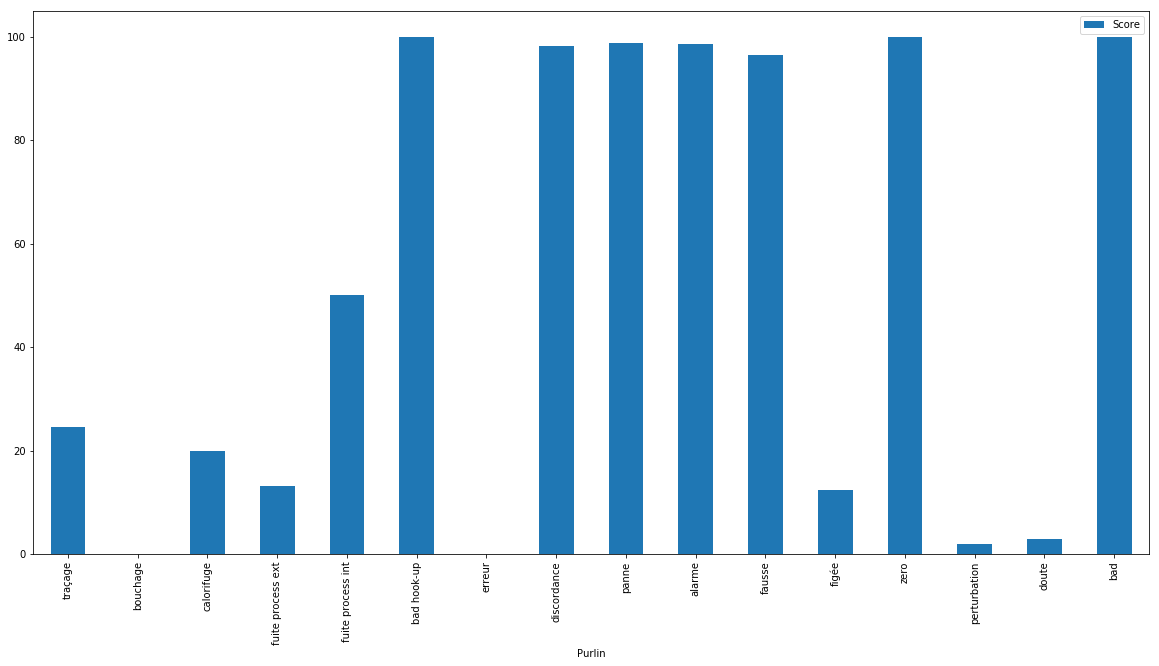

In [356]:
check_rule_validity(df)

In [402]:
df.to_excel('ttt.xlsx')

In [ ]:
re